In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time, TimeDelta

In [2]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

In [3]:
def load_file(path):
    ncols = 1+4*3+1
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

The file below is obtained by running the `vlbi_planning.script` GMAT script.

In [4]:
data = load_file('/home/daniel/jupyter_notebooks/dslwp/vlbi_report.txt')
t = Time(mjd2unixtimestamp(data[:,0]), format='unix')
ta = data[:,-1]

In [5]:
def distance(x):
    return np.sqrt(np.sum(x**2, axis=1))

def elevation(x):
    return np.rad2deg(np.arcsin(x[:,2]/distance(x)))

In [6]:
groundstations = ['Dwingeloo', 'Shahe', 'Harbin', 'Wakayama']
elev_mask = 5
obs_times_start = Time(['2019-06-03 03:05', '2019-06-04 07:00', '2019-06-05 07:00', '2019-06-06 07:00', '2019-06-07 08:00'])
obs_times_end = obs_times_start + TimeDelta(2*3600, format='sec')

In [7]:
def plot_vlbi_window(start, end):
    sel = (t >= start) & (t <= end)
    fig, ax1 = plt.subplots(figsize = [15,5], facecolor='w')
    ax2 = ax1.twinx()
    min_elev = np.empty(data[sel].shape[0])
    min_elev[:] = np.inf
    for j, gs in enumerate(groundstations):
        x = data[sel, 1 + j*3 : 1 + (j+1)*3]
        elev = elevation(x)
        min_elev[elev < min_elev] = elev[elev < min_elev]
        ax1.plot(t[sel].datetime, elev, label = gs)
    ax2.plot(t[sel].datetime, ta[sel], color = 'purple', linestyle = '--', label = 'True anomaly')
    ax1.set_ylim([0,90])
    ax2.set_ylim([0,360])
    ax1.set_xlim((t[sel][0].datetime, t[sel][-1].datetime))
    for j,obs in enumerate(obs_times_start.datetime):
        if j == 0:
            ax1.axvline(x=obs, color = 'red', label='Observation times (start)', linestyle = '--')
        else:
            ax1.axvline(x=obs, color = 'red', linestyle = '--')
    for j,obs in enumerate(obs_times_end.datetime):
        if j == 0:
            ax1.axvline(x=obs, color = 'red', label='Observation times (end)', linestyle = ':')
        else:
            ax1.axvline(x=obs, color = 'red', linestyle = ':')
    ax1.axhline(y = elev_mask, color = 'grey', linestyle = ':', label = 'Elevation mask')
    ax1.fill_between(t[sel].datetime, 0, 90, where = min_elev >= elev_mask, facecolor = 'green', alpha = 0.1)
    ax1.fill_between(t[sel].datetime, 0, 90, where = min_elev < elev_mask, facecolor = 'red', alpha = 0.1)
    ax1.grid(axis='x')
    ax2.grid(axis='y')
    #plt.legend(loc='upper right')
    ax1.legend()
    ax1.set_ylabel('Elevation (deg)')
    ax2.set_ylabel('True anomaly (deg)', color = 'purple')
    ax1.set_xlabel('UTC time')
    ax1.set_title(f'DSLWP-B elevation and true anomaly {t[sel][0].datetime.strftime("%Y-%m-%d")}')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_major_locator(mdates.HourLocator())

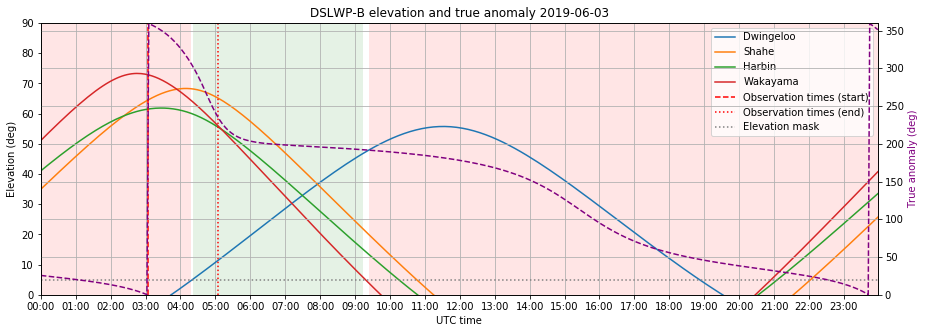

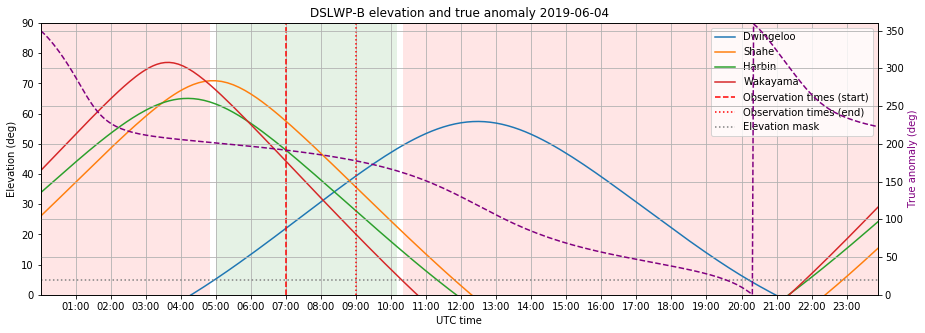

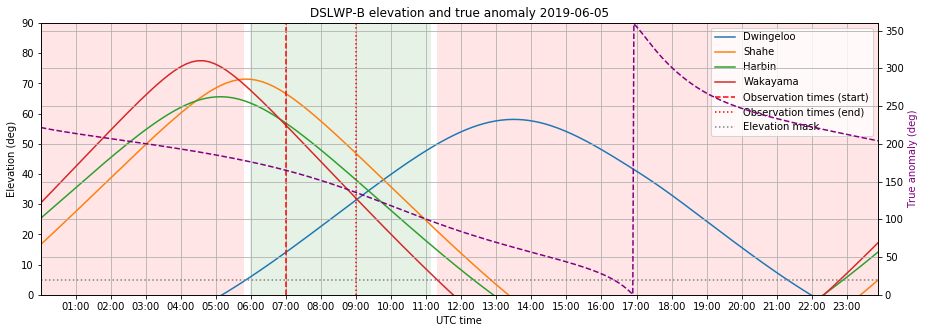

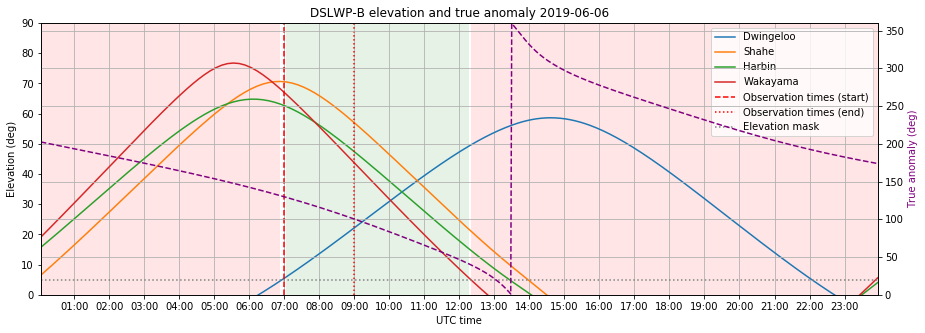

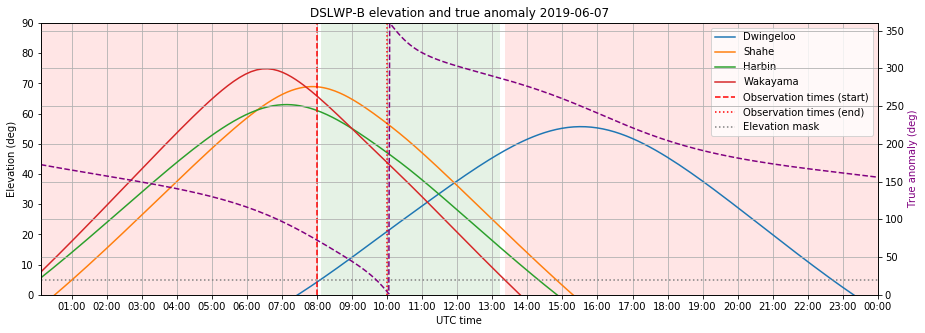

In [8]:
for j in range(int((t[-1] - t[0]).jd)):
    plot_vlbi_window(t[0]+j, t[0]+j+1)